# Housing Prices: Advanced Regression Techniques
## INFS 768
### By John Herbert

## Part I: Importing and Examining the Data

First step will be to import all the libraries and functions we need for this analysis

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn as sk
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install dataframe_image
import dataframe_image as dfi

import copy
from scipy.stats import skew
from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# hd_2.to_csv(r'data\hd_2.csv')

Next we will import the dataset using *read_csv* and giving an initial glance with the *head* function

In [39]:
hd = pd.read_csv('HousingData.csv')
hd.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We can see that the dataset has 1,460 rows and 81 columns.

In [40]:
print('The shape of the dataset is:',hd.shape)

The shape of the dataset is: (1460, 81)


From the above examination, the dataset have a mix of categorical and numeric variables. The variables need to be broken out between the 2 classes for the analysis.

In [4]:
numv = list( hd.loc[:,hd.dtypes != 'object'].drop('Id',axis=1).columns.values )
catv = list( hd.loc[:,hd.dtypes == 'object'].columns.values )
print('The number of numerical variables (including target):',len(numv))
print('The Number of categorical variables:',len(catv))

The number of numerical variables (including target): 37
The Number of categorical variables: 43


I also need to determine which variables contain missing values, and how many. The description of the data from the Kaggle website states that many missing variables are a specific category, however we need to examine it to makes sure the data is in line with the description.

## Part II: Handling Null Values

In [5]:
# Creating the summary table of missing values and datatypes for training
hdtypes = pd.DataFrame(hd.dtypes)
hdtypes.columns = ['class']
hdnull = hd.isnull().sum()
hdnull = hdnull[hdnull!=0]
hdnull = pd.DataFrame(hdnull)
hdnull.columns = ['tot_null']
hdnull['perc_null'] = hdnull['tot_null']/hd.shape[0]
hdnull = hdnull.join(hdtypes,how='inner')
hdnull.sort_values(by='tot_null',ascending=False)

,tot_null,perc_null,class
PoolQC,1453,0.995205,object
MiscFeature,1406,0.963014,object
Alley,1369,0.937671,object
Fence,1179,0.807534,object
FireplaceQu,690,0.472603,object
LotFrontage,259,0.177397,float64
GarageType,81,0.055479,object
GarageYrBlt,81,0.055479,float64
GarageFinish,81,0.055479,object
GarageQual,81,0.055479,object


There are many null values that are in line with the description of the data. For example, all the garage variables that have null values should be the category "no garage." 

However, when examining the the basement variables, we can see that *BsmtExposure* and *BsmtFinType2* have one more missing variable than the rest which means these values are truely missing and should in a seperate category.

Finally, *MasVnrArea*, *MasVnrType*, and *Electrical* has no literature on missing values, therefore these are true missing values. 

In [6]:
# Dropping categorical variables that have too many missing values from training and test sets
hd_2 = hd.drop(['PoolQC','MiscFeature','Alley','Fence','Id'],axis=1)

# replacing missing categorical variables from training and test sets
hd_2.fillna({'FireplaceQu':'no_fp', 'GarageType':'no_g','GarageQual':'no_g',
            'GarageCond':'no_g','GarageFinish':'no_g','BsmtExposure':'no_b','BsmtFinType2':'no_b',
            'BsmtFinType1':'no_b','BsmtCond':'no_b','BsmtQual':'no_b',
            'MasVnrType':'missing','MasVnrType':'missing','Electrical':'missing'}, inplace=True)

# Replacing actual missing values from 2 cateogrical variables
hd_2.loc[hd_2.index == 948 ,'BsmtExposure'] = 'missing'
hd_2.loc[hd_2.index == 332 ,'BsmtFinType2'] = 'missing'

The variables *PoolQC*, *MiscFeatures*, *Alley*, and *Fence* have more than 80% missing values, therefore they will not have much, if any correlation to the target and will be dropped as they most likely will add noise to the model. In addition, *ID* holds no predictive information so that will be dropped as well.

The 2 missing values from *BsmtExposure* and *BsmtFinType2* that have basements have been replaced with a new category *missing*.

The rest of the categorical variables with missing values will be replaced with categories stating that there is no garage or no basement in the house.

After these transformations, the only remaining variables with missing values will be the continuous inputs.

In [7]:
hd_2null = hd_2.isnull().sum()
hd_2null[hd_2null > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

We can see the remaining missing values are the continuous variables: *LotFrontage*, *GarageYrBlt*, and *MasVnrArea*.

## Part III: Splitting the Dataset into Training and Test

In [8]:
np.random.seed(42)
hd_train,hd_test = train_test_split(hd_2,test_size=0.10, random_state=42)

In [9]:
print('The shape of the training dataset:',hd_train.shape)
print('The shape of the test dataset:',hd_test.shape)

The shape of the training dataset: (1314, 76)
The shape of the test dataset: (146, 76)


Since the data set is only 1,481 rows, and is small, we want to use as much of the data to train our model. Therefore, we will set the train-test ratio to 90-10, respectfully.

As expected, there are now only 76 (81 less the variables we dropped) in both subsets.

## Part IV: Replacing Missing Continuous Variable Records Subsets

For the 3 continuous variables with missing values, they will be replaced with the mean of each variable per neighborhood. To ensure that the test data is not influenced by the training data, the mean for the training data set will be used in the test dataset.

In [10]:
# Replacing continuous variables with mean of their neighborhood
train_means = hd_train.groupby(['Neighborhood'])['LotFrontage','GarageYrBlt','MasVnrArea'].mean()
train_means['Neighborhood'] = train_means.index 

hd_test.loc[hd_test['LotFrontage'].isnull(),'LotFrontage'] = hd_test['Neighborhood'].map(train_means.LotFrontage)
hd_test.loc[hd_test['GarageYrBlt'].isnull(),'GarageYrBlt'] = hd_test['Neighborhood'].map(train_means.GarageYrBlt)
hd_test.loc[hd_test['MasVnrArea'].isnull(),'MasVnrArea'] = hd_test['Neighborhood'].map(train_means.MasVnrArea)

hd_train['LotFrontage'] = hd_train.groupby(['Neighborhood'])['LotFrontage']\
    .transform(lambda x: x.fillna(x.mean()))
hd_train['GarageYrBlt'] = hd_train.groupby(['Neighborhood'])['GarageYrBlt']\
    .transform(lambda x: x.fillna(x.mean()))
hd_train['MasVnrArea'] = hd_train.groupby(['Neighborhood'])['MasVnrArea']\
    .transform(lambda x: x.fillna(x.mean()))

We can see below that all null values are now satisfied in the training and test datasets.

In [11]:
hd_trainnull = hd_train.isnull().sum()
print(hd_trainnull[hd_trainnull > 0])

hd_testnull = hd_test.isnull().sum()
print(hd_testnull[hd_testnull > 0])

Series([], dtype: int64)
Series([], dtype: int64)


## Part V: Further Transformation of Continuous Variables

Before any transformation of the variables, we first need to see if they are normalized and not skewed, as well as visualize the outliers. Therefore, we will examine historgrams of each of the numeric variables.

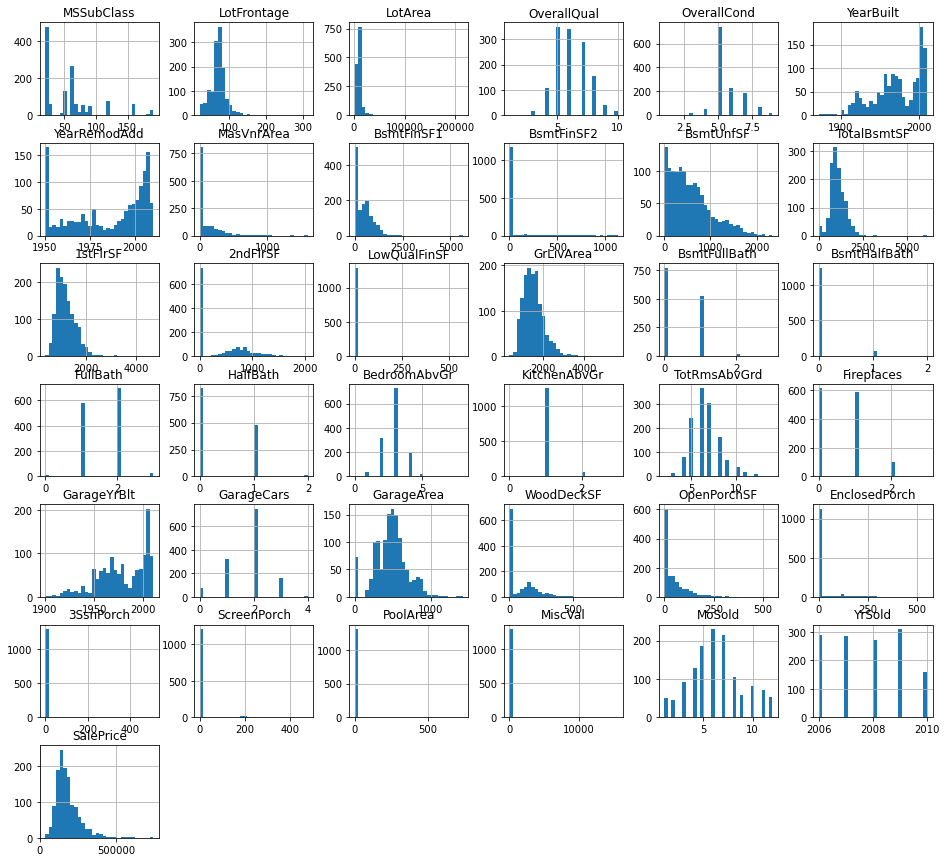

In [12]:
# PLotting histograms to determine which variables need transformation
hd_train.hist(bins=30, figsize=(16, 15))
plt.show()

Through examination of the the histograms, we can see that multiple variables are skewed, including the target variable *SalePrice*. Therefore, these will need log transformation to see if we can normalize them. 

In addition, *LowQualFinSF*, *3SsnPorch* , *ScreenPorch*, *PoolArea*, and *MiscVal* have a large number of zero values, therefore they will be dropped from the datasets as they will not have a high correlation to *SalePrice* and will add noise to the analysis.

Also, there are a number of variables with large right skewed data points. Any value that is over the 99th percentile in these variables will be converted to the 99th percentile in the training dataset. 

In [13]:
hd_train = hd_train.drop(['LowQualFinSF','3SsnPorch','ScreenPorch','PoolArea','MiscVal'],axis=1)
hd_test = hd_test.drop(['LowQualFinSF','3SsnPorch','ScreenPorch','PoolArea','MiscVal'],axis=1)

outliers = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','WoodDeckSF',
            'OpenPorchSF','EnclosedPorch']

for i in outliers:
    h = np.percentile(hd_train[i], 99)
    hd_train[i] = np.where(hd_train[i]>h,h,hd_train[i])

To determine which numeric variables need log transformation, we will be determine which variables have a skewness of over 0.5 in the training dataset, and apply to the training and test dataset. This is to make sure that the test set is not influenced by the training dataset.

Below is the list of each numeric variable and its skew score. Wewill need to seperate each variable into 2 groups: Categorical and Numeric for this analysis as well as more further on in the analysis.

In [14]:
# Seperating categorical and continuous variables
cats = ['Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
        'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
        'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
        'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
        'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','MSZoning','SaleCondition',
        'MoSold']

num = ['MSSubClass','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
       'GarageYrBlt','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF',
       'OpenPorchSF','EnclosedPorch','SalePrice','OverallQual','OverallCond','BsmtFullBath',
       'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageCars','YrSold']

for i in num:
    print(i+': {}'.format(round(skew(hd_train[i]),2)))

MSSubClass: 1.39
LotFrontage: 0.25
LotArea: 2.7
YearBuilt: -0.61
YearRemodAdd: -0.5
MasVnrArea: 1.96
BsmtFinSF1: 0.66
BsmtFinSF2: 3.92
BsmtUnfSF: 0.93
GarageYrBlt: -0.56
TotalBsmtSF: 0.24
1stFlrSF: 0.65
2ndFlrSF: 0.79
GrLivArea: 0.79
GarageArea: 0.09
WoodDeckSF: 1.28
OpenPorchSF: 1.72
EnclosedPorch: 2.76
SalePrice: 1.73
OverallQual: 0.21
OverallCond: 0.73
BsmtFullBath: 0.63
BsmtHalfBath: 4.12
FullBath: 0.03
HalfBath: 0.68
BedroomAbvGr: 0.24
KitchenAbvGr: 4.38
Fireplaces: 0.65
GarageCars: -0.37
YrSold: 0.08


In [15]:
# Transform continuous variables to log that have skewness over 0.5
skewed = np.array(num)[np.abs(skew(hd_train[num])) > 0.5]
hd_train[skewed] = np.log1p(hd_train[skewed])
hd_test[skewed] = np.log1p(hd_test[skewed])

Now that we have transformed the data, we can examine the histograms again to see if the data is more normalized.

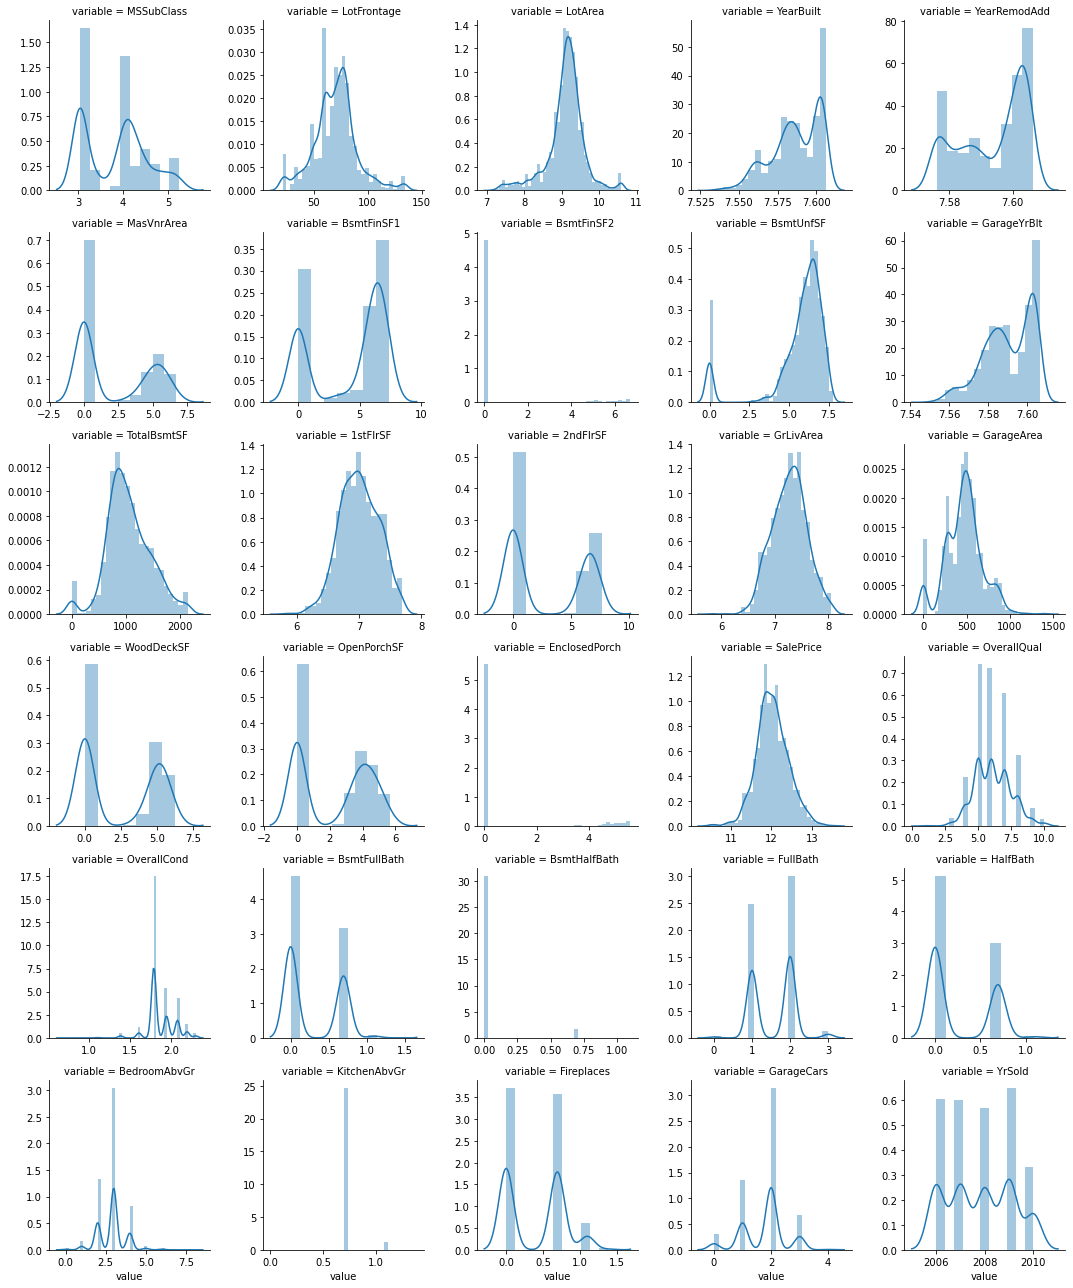

In [16]:
# visualize the distribution of each numerical feature after transformations
temp = pd.melt(hd_train[num])
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()
#plt.savefig('trans_histogram.png')

## Part VI: Creating Dummy Variables 

In order to run the models, the categorical variables need to be transformed into dummy variables. Also, one of the cateogrical variables needs to be excluded for each transformation in order to avoid the dummy variable trap.

In [17]:
# Creating the dummy variables from the categorical data
hd_train = pd.get_dummies(hd_train,columns=cats,drop_first=True)
hd_test = pd.get_dummies(hd_test,columns=cats,drop_first=True)

# Get missing columns in the training test
missing_cols = set(hd_train.columns ) - set(hd_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    hd_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
hd_test = hd_test[hd_train.columns]

In [18]:
# Confirming training and test sets number of variables match
print('The shape of the training dataset:',hd_train.shape)
print('The shape of the test dataset:',hd_test.shape)

The shape of the training dataset: (1314, 254)
The shape of the test dataset: (146, 254)


## Part VII: Standardizing the Data

Models generally will work better when standardized, therefore we will use the *RobustScaler* function on the numeric variables.

First, however, we will seperate the input variables from the target for both the training and test sets.

In [19]:
X_train = hd_train.loc[:,hd_train.columns != 'SalePrice']
y_train = hd_train['SalePrice']

X_test = hd_test.loc[:,hd_test.columns != 'SalePrice']
y_test = hd_test['SalePrice']

num_t = ['MSSubClass','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
         'BsmtUnfSF','GarageYrBlt','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF',
         'OpenPorchSF','EnclosedPorch','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath',
         'HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageCars','YrSold']

In [20]:
# Preforming standardization using RoBustScaler() on all numeric values 
# that are not dummy variables. This is more robust to outliers.

# fit the training set only, then transform both the training and test sets
scaler = RobustScaler()
X_train[num_t]= scaler.fit_transform(X_train[num_t])
X_test[num_t]= scaler.transform(X_test[num_t])

print('The shape of the training inputs are:',X_train.shape)
print('The shape of the test inputs are:',X_test.shape)

The shape of the training inputs are: (1314, 253)
The shape of the test inputs are: (146, 253)


## Part VIII: Variable Selection

We will first use the *XGBRegressor* function to see which input variables have the most importance and reduce the number of variables used in our model. This should help with reducing overfitting and noise in the inputs and scale down some of the non-correlated variables.

For cleaness of this document, we will only show the top 20 variables in order of importance.

In [21]:
np.random.seed(42) 
xgb = XGBRegressor(seed=42)
xgb.fit(X_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp.head(20))

                      Importance
OverallQual             0.096046
Exterior1st_BrkComm     0.072944
Fireplaces              0.070160
MSZoning_RL             0.058919
CentralAir_Y            0.054880
GarageType_Attchd       0.050185
GarageCars              0.042268
GrLivArea               0.033890
TotalBsmtSF             0.026159
MSZoning_RM             0.024137
KitchenAbvGr            0.020078
Functional_Sev          0.016387
Neighborhood_Crawfor    0.015029
Heating_GasA            0.014122
RoofStyle_Gambrel       0.013901
GarageType_Basment      0.012325
Neighborhood_OldTown    0.011680
Street_Pave             0.011615
Exterior1st_Stucco      0.011468
Exterior1st_BrkFace     0.010877


We will use the Reclusive Feature Elimination Cross Validation (RFECV) method to eliminate redundant input variables and RMSE as the scorer or determiner. This will only be done on the training set, but the features that are determined by this will be applied to the training and test set. Cross validation will be used to determine how many variables will be kept to produce the lowest RMSE.




In [22]:
np.random.seed(42) 
# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

neg_rmse = make_scorer(nrmse)

estimator = XGBRegressor(seed=42)
selector = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
selector = selector.fit(X_train, y_train)

features_kept = X_train.columns.values[selector.support_] 
X_train = X_train[features_kept]
X_test = X_test[features_kept]

print("The number of selected inputs is: {}".format(selector.n_features_),'\n')
print(features_kept) 

The number of selected inputs is: 50 

['OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'BsmtFinSF1'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'FullBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'Fireplaces' 'GarageYrBlt' 'GarageCars' 'GarageArea'
 'OpenPorchSF' 'EnclosedPorch' 'Street_Pave' 'LotConfig_FR3'
 'Neighborhood_BrkSide' 'Neighborhood_Crawfor' 'Neighborhood_Edwards'
 'Neighborhood_NAmes' 'Neighborhood_OldTown' 'Neighborhood_StoneBr'
 'Condition1_Norm' 'HouseStyle_SLvl' 'Exterior1st_BrkComm'
 'Exterior1st_BrkFace' 'ExterCond_Fa' 'BsmtQual_Gd' 'BsmtExposure_Gd'
 'BsmtExposure_No' 'Heating_GasA' 'CentralAir_Y' 'Functional_Maj2'
 'Functional_Sev' 'Functional_Typ' 'GarageType_Attchd'
 'GarageType_Basment' 'GarageQual_Fa' 'SaleType_ConLD' 'SaleType_New'
 'MSZoning_RL' 'MSZoning_RM' 'SaleCondition_Family' 'SaleCondition_Normal'
 'MoSold_2' 'MoSold_12']


## Part IX: Model 1: Linear Regression

To set a baseline for our model, to see if we can improve our score, we built a multiple linear regression model. In addition, we use a 10 fold cross validation to validate and tune our parameters. For linear regression model, since there are not any parameters that need tuning, this will only be used for the neural network model.

In [23]:
np.random.seed(42) 
linregr = linear_model.LinearRegression()
scores = cross_val_score(linregr,X_train,y_train,cv=10, scoring="neg_root_mean_squared_error")
print('Model 1 Cross Validation RMSE: {0:0.4f}'.format(np.mean(scores)*-1))
scores2 = cross_val_score(linregr,X_train,y_train,cv=10, scoring="r2")
print('Model 1 Cross Validation R Squared: {0:0.4f}'.format(np.mean(scores2)))

Model 1 Cross Validation RMSE: 0.1336
Model 1 Cross Validation R Squared: 0.8807


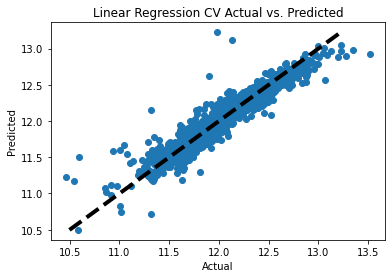

In [24]:
np.random.seed(42) 
y_pred_cv = cross_val_predict(linregr,X_train,y_train,cv=10)

fig,ax = plt.subplots()
ax.scatter(y_train, y_pred_cv)
ax.plot([y_pred_cv.min(), y_pred_cv.max()], [y_pred_cv.min(), y_pred_cv.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Linear Regression CV Actual vs. Predicted')
plt.show()

In [25]:
linregr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

Based on the list of parameters from the linear regression model, there does not appear to be any parameters that need adjusting since the data was normalized already in the variable selection process.

To determine how the model preforms on new data, we will fit the linear regression model to the the training data set and predict the test data. We will also use RMSE and R squared to determine the model fit.

In [26]:
np.random.seed(42) 
linregr.fit(X_train,y_train)
y_pred = linregr.predict(X_test)
m1_RSME = mean_squared_error(y_test,y_pred)
print('Model 1 RMSE on Test: {0:0.4f}'.format(m1_RSME))
m1_r2 = r2_score(y_test,y_pred)
print('Model 1 R-Squared on Test: {0:0.4f}'.format(m1_r2))

Model 1 RMSE on Test: 0.0127
Model 1 R-Squared on Test: 0.9352


The cross validation method seems to show less accuracy than what was done on the test. However, this would be expected as the validation method is using a larger data set and has more outliers and variation.

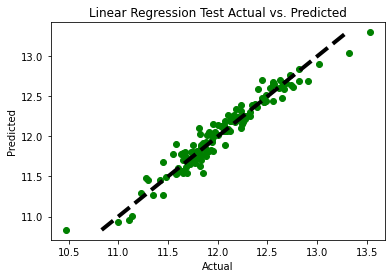

In [27]:
fig,ax = plt.subplots()
ax.scatter(y_test, y_pred,color='green')
ax.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Linear Regression Test Actual vs. Predicted')
plt.show()

According to the RMSe and R squared, the test data set appears to fit the data better than the CV validation. This may be explained becuase the cross validation sets aside 10% of the data for testing each iteration of the cross validation, where the test model fit uses all the training data. In addition, the sample size of the test data may be too small and giving an accurate reading on what a new set of data will be able to predict.

## Part X: Model 2: Neural Network

To see if we can improve on the lienar regression model, we will run a Multilayer Perceptron Neural Network. However, theere are a number parameters that need to be determine in order to get the lowest RMSE in the cross validation model as possible.

Below are the parameters for the sklearn *MLPRegressor* function.

In [28]:
np.random.seed(42) 
mlp = MLPRegressor(random_state=42)
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

We will focus on 4 of the parameters, as they are the biggest contributors to how well the model fits. Those are the number of hidden layers in the perceptron model, the solve method, alpha, and what type of learning rate.

We will use the *RandomizedSearchCV* function to iterative randomly through each of the parameters and the parameters settings for each to determine which setting for each parameter will optimize by determine which mix has the lowest absolute error. 

In [29]:
np.random.seed(42) 

parameter_space = {
    'hidden_layer_sizes': [(sp_randint.rvs(1,100,1),sp_randint.rvs(1,100,1),), 
                                          (sp_randint.rvs(1,100,1),)],
    'activation': ['tanh', 'relu', 'identity'],
    'solver': ['lbfgs', 'sgd', 'adams'],
    'alpha': uniform(0.0001, 0.9),
    'learning_rate': ['constant','adaptive','invscaling']}

In [30]:
np.random.seed(42) 
mlp_cv = RandomizedSearchCV(mlp,parameter_space,n_iter=100,random_state=42,scoring='neg_root_mean_squared_error')
mlp_tuned = mlp_cv.fit(X_train,y_train)

In [31]:
np.random.seed(42) 
from pprint import pprint
pprint(mlp_tuned.best_estimator_.get_params())

{'activation': 'tanh',
 'alpha': 0.8235637079894027,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (53, 94),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


Above we can see the optimal parameter setting to use in our model. It recommends an alpha of roughly 0.82, a hyperbolic tan activation function for the hidden layers, two hidden layer, 53 neurons in the first hidden layer and 94 in the second, and a quasi-Newton weight optimation method. Since the *lbfgs* solver is being used, learning rate is not applicable. 

We will use the same validation and testing method as the lienar model for the neural network.

In [32]:
mlp_tuned = MLPRegressor(activation='tanh',alpha= 0.8235637079894027,
                        hidden_layer_sizes=(53, 94),
                        solver='lbfgs',random_state=42)
# ,learning_rate='invscaling'
mlp_tuned = mlp_tuned.fit(X_train,y_train)

In [33]:
scores3 = cross_val_score(mlp_tuned,X_train,y_train,cv=10, scoring="neg_root_mean_squared_error")
print('Model 2 Cross Validation RMSE: {0:0.4f}'.format(np.mean(scores3)*-1))
scores4 = cross_val_score(mlp_tuned,X_train,y_train,cv=10, scoring="r2")
print('Model 2 Cross Validation R Squared: {0:0.4f}'.format(np.mean(scores4)))

Model 2 Cross Validation RMSE: 0.1307
Model 2 Cross Validation R Squared: 0.8866


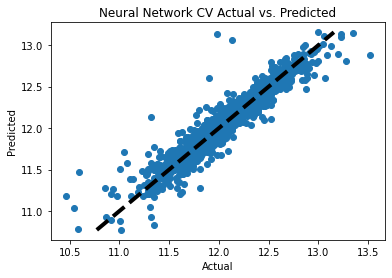

In [34]:
y_pred_cv2 = cross_val_predict(mlp_tuned,X_train,y_train,cv=10)

fig,ax = plt.subplots()
ax.scatter(y_train, y_pred_cv2)
ax.plot([y_pred_cv2.min(), y_pred_cv2.max()], [y_pred_cv2.min(), y_pred_cv2.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Neural Network CV Actual vs. Predicted')
plt.show()

In [35]:
y_pred2 = mlp_tuned.predict(X_test)
m2_RSME = mean_squared_error(y_test,y_pred2)
print('Model 2 RMSE on Test: {0:0.4f}'.format(m2_RSME))
m2_r2 = r2_score(y_test,y_pred2)
print('Model 2 R-Squared on Test: {0:0.4f}'.format(m2_r2))

Model 2 RMSE on Test: 0.0188
Model 2 R-Squared on Test: 0.9043


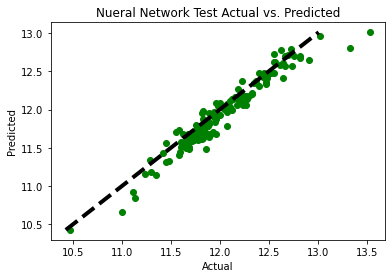

In [36]:
fig,ax = plt.subplots()
ax.scatter(y_test, y_pred2,color='green')
ax.plot([y_pred2.min(), y_pred2.max()], [y_pred2.min(), y_pred2.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Nueral Network Test Actual vs. Predicted')
plt.show()

The neural network model has the same trend as the linear where the cross validation had a lower score than the test set, which is stronger evidence that the test set was not large enough.

## Part XI: Summary

In conclusion, the neural network model performs better with validation than the linear regression model, but only marginally. However the linear regression performs better than the neural network on the test set. This is summarized in the table and graphs below.

Since the neural network did not perform better than the linear regression, or only marginally so, it may not be the best model for predictions. Testing different models, as well as testing more data would be advisable.

In [37]:
summary_dat = {'Model':['Linear Regression CV','Linear Regression Test','Neural Network CV','Neural Network Test'],
               'RMSE':[np.mean(scores)*-1,m1_RSME,np.mean(scores3)*-1,m2_RSME],
               'R Squared':[np.mean(scores2),m1_r2,np.mean(scores4),m2_r2]}

summary_df = pd.DataFrame(summary_dat,columns=['Model','RMSE','R Squared'])

summary_df

,Model,RMSE,R Squared
0,Linear Regression CV,0.133631,0.880727
1,Linear Regression Test,0.012704,0.935176
2,Neural Network CV,0.130706,0.886569
3,Neural Network Test,0.018758,0.904284


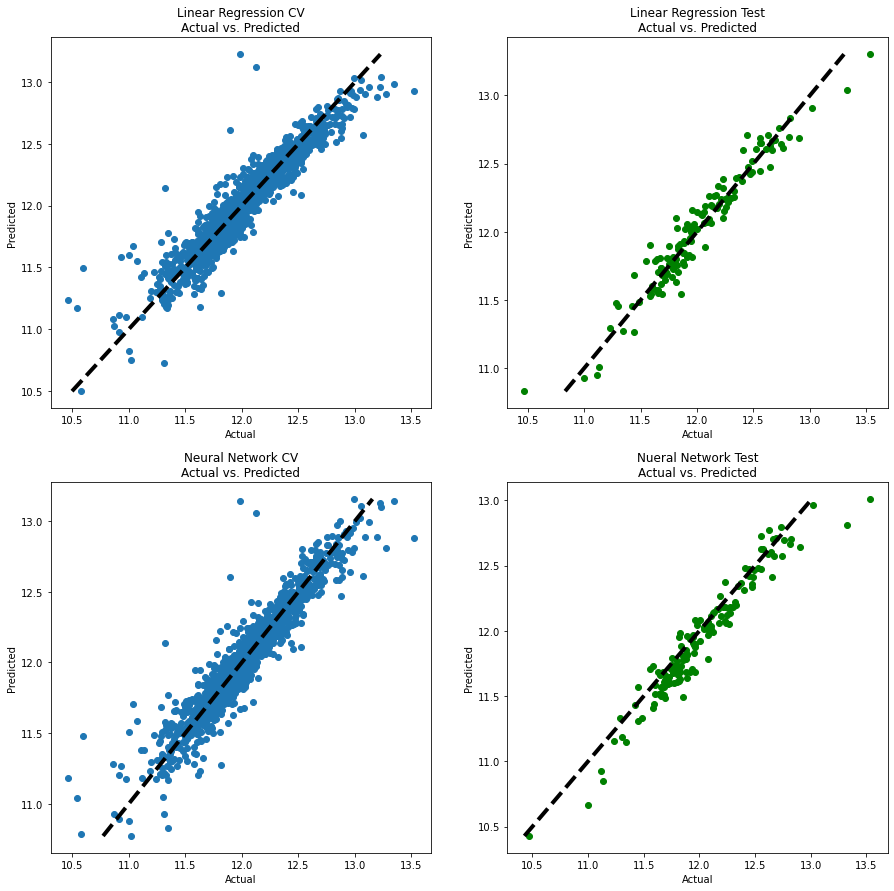

In [38]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].scatter(y_train, y_pred_cv)
ax[0,0].plot([y_pred_cv.min(), y_pred_cv.max()], [y_pred_cv.min(), y_pred_cv.max()], 'k--', lw=4)
ax[0,0].set_xlabel('Actual')
ax[0,0].set_ylabel('Predicted')
ax[0,0].set_title('Linear Regression CV\nActual vs. Predicted')

ax[0,1].scatter(y_test, y_pred,color='green')
ax[0,1].plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
ax[0,1].set_xlabel('Actual')
ax[0,1].set_ylabel('Predicted')
ax[0,1].set_title('Linear Regression Test\nActual vs. Predicted')

ax[1,0].scatter(y_train, y_pred_cv2)
ax[1,0].plot([y_pred_cv2.min(), y_pred_cv2.max()], [y_pred_cv2.min(), y_pred_cv2.max()], 'k--', lw=4)
ax[1,0].set_xlabel('Actual')
ax[1,0].set_ylabel('Predicted')
ax[1,0].set_title('Neural Network CV\nActual vs. Predicted')

ax[1,1].scatter(y_test, y_pred2,color='green')
ax[1,1].plot([y_pred2.min(), y_pred2.max()], [y_pred2.min(), y_pred2.max()], 'k--', lw=4)
ax[1,1].set_xlabel('Actual')
ax[1,1].set_ylabel('Predicted')
ax[1,1].set_title('Nueral Network Test\nActual vs. Predicted')
plt.show()